# Thermal Training Stats

In [ ]:
import numpy as np
import cv2
import pickle
from pathlib import Path
from tqdm import tqdm
from collections import Counter

# --- CONFIGURATION ---
DATA_ROOT = "/mnt/sbackup/Server_3/harshr/m2p2_data2"
SPLIT = "train"

def get_image_paths(root, split):
    """Finds all .pkl files and extracts image paths"""
    data_root = Path(root) / split
    files = list(data_root.glob("*.pkl"))
    
    all_thermal_paths = []
    all_depth_paths = []
    
    print("Gathering file paths...")
    for file in files:
        with open(file, "rb") as f:
            data = pickle.load(f)
            t_paths = data['thermal_paths']
            d_paths = data['depth_paths']
            
            if isinstance(t_paths, np.ndarray): t_paths = t_paths.tolist()
            if isinstance(d_paths, np.ndarray): d_paths = d_paths.tolist()
            
            all_thermal_paths.extend(t_paths)
            all_depth_paths.extend(d_paths)
            
    return all_thermal_paths, all_depth_paths

def check_bit_depths():
    thermal_paths, depth_paths = get_image_paths(DATA_ROOT, SPLIT)
    print(f"Found {len(thermal_paths)} image pairs.")
    print("Checking bit depths... (This may take a moment)\n")
    
    thermal_types = Counter()
    depth_types = Counter()
    non_8bit_thermal_samples = []

    for t_path, d_path in tqdm(zip(thermal_paths, depth_paths), total=len(thermal_paths)):
        
        # --- Check Thermal ---
        # Read UNCHANGED to see the true file format
        t_img = cv2.imread(t_path, cv2.IMREAD_UNCHANGED)
        
        if t_img is None:
            thermal_types['Corrupt/None'] += 1
        else:
            t_type = str(t_img.dtype)
            thermal_types[t_type] += 1
            
            # Save a few examples if we find non-8-bit thermal
            if t_img.dtype != np.uint8 and len(non_8bit_thermal_samples) < 5:
                non_8bit_thermal_samples.append((t_path, t_type))

        # --- Check Depth ---
        # Load exactly how you load in dataloader
        try:
            d_img = np.load(d_path)
            d_type = str(d_img.dtype)
            depth_types[d_type] += 1
        except:
            depth_types['Corrupt/None'] += 1

    # --- REPORT ---
    print("\n" + "="*40)
    print("RESULTS")
    print("="*40)
    
    print(f"\nTHERMAL IMAGES:")
    for dtype, count in thermal_types.items():
        status = "✅ OK" if dtype == 'uint8' else "⚠️ WARNING"
        print(f"  {dtype}: {count} images ({status})")
        
    if non_8bit_thermal_samples:
        print("\n  [!] Found non-8-bit thermal images! Examples:")
        for path, dtype in non_8bit_thermal_samples:
            print(f"      - {dtype}: {path}")
        print("  ACTION: If you see 'uint16', you MUST add the normalization check to your DataLoader.")

    print(f"\nDEPTH IMAGES:")
    for dtype, count in depth_types.items():
        print(f"  {dtype}: {count} images")

# --- RUN ---
if __name__ == "__main__":
    check_bit_depths()

Gathering file paths...
Found 82538 image pairs.
Checking bit depths... (This may take a moment)



TypeError: 'int' object is not subscriptable

In [ ]:
import numpy as np
import cv2
import torch
import pickle
from pathlib import Path
from tqdm import tqdm

# ============================================================================
# CONFIGURATION - MUST MATCH YOUR DATALOADER EXACTLY
# ============================================================================
DATA_ROOT = "/mnt/sbackup/Server_3/harshr/m2p2_data2"
SPLIT = "train"

# Image dimensions
ORIG_W = 1280
ORIG_H = 1024
TARGET_H = 256
TARGET_W = 256

# Cropping (from your dataloader)
CROP_TOP = 165
CROP_BOTTOM = 74

# Depth scaling (from your dataloader)
CLIP_DISTANCE = 30.0
REG_FACTOR = 3.7  # ← Fixed! Was 16.7 in your script


def get_image_paths(root, split):
    """Finds all .pkl files and extracts image paths"""
    data_root = Path(root) / split
    files = list(data_root.glob("*.pkl"))
    
    all_thermal_paths = []
    all_depth_paths = []
    
    print("Gathering file paths...")
    for file in files:
        with open(file, "rb") as f:
            data = pickle.load(f)
            t_paths = data['thermal_paths']
            d_paths = data['depth_paths']
            
            if isinstance(t_paths, np.ndarray):
                t_paths = t_paths.tolist()
            if isinstance(d_paths, np.ndarray):
                d_paths = d_paths.tolist()
            
            all_thermal_paths.extend(t_paths)
            all_depth_paths.extend(d_paths)
            
    return all_thermal_paths, all_depth_paths


def crop_and_resize(img):
    """
    Applies same crop and resize as your dataloader.
    This is CRITICAL - stats must be computed on same resolution!
    """
    # Crop (remove U-shaped borders)
    cropped = img[CROP_TOP:ORIG_H - CROP_BOTTOM, 0:ORIG_W]
    
    # Resize to target size
    resized = cv2.resize(cropped, (TARGET_W, TARGET_H), interpolation=cv2.INTER_NEAREST)
    
    return resized


def preprocess_thermal(img_path):
    """
    Reads thermal and applies same preprocessing as dataloader.
    NOTE: Your dataloader has CLAHE commented out, so we don't use it here!
    """
    img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        return None
    
    # Crop and resize FIRST (geometry transformation)
    img = crop_and_resize(img)
    
    # Convert to float32 [0, 1] - no CLAHE since it's commented in your dataloader
    if img.dtype != np.uint8:
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    
    img = img.astype(np.float32) / 255.0
    
    return img

def preprocess_depth(img_path):
    """
    Reads depth, applies Log Scaling, returns [0, 1]
    Must match your training logic exactly.
    """
    depth = np.load(img_path)
    if depth is None: return None
    # Crop and resize (still NumPy)
    depth = crop_and_resize(depth)
    depth = depth.astype('float32')
    
    # --- LOGIC FROM YOUR PIPELINE ---
    depth = np.clip(depth, 0.1, CLIP_DISTANCE)
    depth = depth / CLIP_DISTANCE              # Linear Normalize
    depth = 1.0 + np.log(depth) / REG_FACTOR   # Log Scale
    depth = np.clip(depth, 0.0, 1.0)           # Final Clamp
    
    return depth

def calculate_stats():
    """Computes mean and std for thermal and depth"""
    thermal_paths, depth_paths = get_image_paths(DATA_ROOT, SPLIT)
    print(f"Found {len(thermal_paths)} pairs")
    print(f"Image processing: Crop({CROP_TOP}, {CROP_BOTTOM}) -> Resize({TARGET_H}x{TARGET_W})")
    print(f"Depth scaling: clip={CLIP_DISTANCE}, reg_factor={REG_FACTOR}")
    print("\nStarting calculation...\n")
    
    # Accumulators
    t_sum, t_sq_sum = 0.0, 0.0
    d_sum, d_sq_sum = 0.0, 0.0
    n_pixels = 0
    skipped = 0
    
    # Process all images
    for t_path, d_path in tqdm(zip(thermal_paths, depth_paths), total=len(thermal_paths)):
        try:
            # Process thermal
            t_img = preprocess_thermal(t_path)
            if t_img is None:
                skipped += 1
                continue
            
            # Process depth
            d_img = preprocess_depth(d_path)
            if d_img is None:
                skipped += 1
                continue
            
            # Flatten and accumulate
            t_flat = t_img.flatten()
            d_flat = d_img.flatten()
            
            t_sum += np.sum(t_flat)
            t_sq_sum += np.sum(t_flat ** 2)
            
            d_sum += np.sum(d_flat)
            d_sq_sum += np.sum(d_flat ** 2)
            
            n_pixels += t_flat.size
            
        except Exception as e:
            print(f"\nError processing {t_path}: {e}")
            skipped += 1
            continue
    
    # Calculate mean and std
    t_mean = t_sum / n_pixels
    t_std = np.sqrt((t_sq_sum / n_pixels) - (t_mean ** 2))
    
    d_mean = d_sum / n_pixels
    d_std = np.sqrt((d_sq_sum / n_pixels) - (d_mean ** 2))
    
    print(f"\nProcessed: {len(thermal_paths) - skipped} images")
    print(f"Skipped: {skipped} images")
    print(f"Total pixels: {n_pixels:,}")
    
    return (t_mean, t_std), (d_mean, d_std)

# --- EXECUTE ---
(t_mean, t_std), (d_mean, d_std) = calculate_stats()

print("\n" + "="*40)
print("FINAL RESULTS - PASTE THESE INTO YOUR CODE")
print("="*40)
print(f"THERMAL MEAN: {t_mean:.6f}")
print(f"THERMAL STD:  {t_std:.6f}")
print("-" * 20)
print(f"DEPTH MEAN:   {d_mean:.6f}")
print(f"DEPTH STD:    {d_std:.6f}")
print("="*40)

Gathering file paths...
Found 82538 pairs
Image processing: Crop(165, 74) -> Resize(256x256)
Depth scaling: clip=30.0, reg_factor=3.7

Starting calculation...



100%|██████████| 82538/82538 [2:11:12<00:00, 10.48it/s]  


Processed: 82538 images
Skipped: 0 images
Total pixels: 5,409,210,368

FINAL RESULTS - PASTE THESE INTO YOUR CODE
THERMAL MEAN: 0.495356
THERMAL STD:  0.191781
--------------------
DEPTH MEAN:   0.561041
DEPTH STD:    0.295559


In [5]:
# Add this after your main script
import random

def verify_stats(n_samples=10):
    """Quick verification on random samples"""
    thermal_paths, depth_paths = get_image_paths(DATA_ROOT, SPLIT)
    
    # Random sample
    indices = random.sample(range(len(thermal_paths)), n_samples)
    
    print("\n" + "="*60)
    print("VERIFICATION: Checking normalized values on random samples")
    print("="*60)
    
    for idx in indices:
        t_img = preprocess_thermal(thermal_paths[idx])
        d_img = preprocess_depth(depth_paths[idx])
        
        if t_img is not None and d_img is not None:
            # Normalize using computed stats
            t_norm = (t_img - t_mean) / t_std
            d_norm = (d_img - d_mean) / d_std
            
            print(f"\nSample {idx}:")
            print(f"  Thermal normalized - min: {t_norm.min():.2f}, max: {t_norm.max():.2f}, mean: {t_norm.mean():.2f}")
            print(f"  Depth normalized   - min: {d_norm.min():.2f}, max: {d_norm.max():.2f}, mean: {d_norm.mean():.2f}")
    
    print("\n✓ After normalization, expect:")
    print("  - Mean ~0.0 (zero-centered)")
    print("  - Values mostly in [-3, +3] range (within 3 std devs)")
    print("="*60)

verify_stats(n_samples=5)

Gathering file paths...

VERIFICATION: Checking normalized values on random samples

Sample 11699:
  Thermal normalized - min: -2.42, max: 1.71, mean: 0.34
  Depth normalized   - min: -1.90, max: 1.49, mean: 0.30

Sample 43854:
  Thermal normalized - min: -2.56, max: 2.12, mean: 0.36
  Depth normalized   - min: -1.90, max: 1.49, mean: 0.29

Sample 71187:
  Thermal normalized - min: -2.44, max: 1.57, mean: 0.25
  Depth normalized   - min: -1.90, max: 1.49, mean: 0.39

Sample 15842:
  Thermal normalized - min: -2.58, max: 1.42, mean: -0.33
  Depth normalized   - min: -1.90, max: 1.49, mean: -0.03

Sample 29362:
  Thermal normalized - min: -2.58, max: 1.10, mean: -0.62
  Depth normalized   - min: -1.90, max: 1.49, mean: -0.25

✓ After normalization, expect:
  - Mean ~0.0 (zero-centered)
  - Values mostly in [-3, +3] range (within 3 std devs)


In [6]:
import sys

def verify_subset_mean():
    # 1. Get a small subset of paths (e.g., 100 images)
    all_t_paths, all_d_paths = get_image_paths(DATA_ROOT, SPLIT)
    sample_size = 100
    sample_t_paths = all_t_paths[:sample_size]
    sample_d_paths = all_d_paths[:sample_size]

    t_sum_sample, d_sum_sample, n_pixels_sample = 0.0, 0.0, 0

    # 2. Replicate preprocessing and summing only
    # NOTE: You'd need to copy the preprocessing logic here, 
    #       or call the individual preprocess_thermal/depth functions.
    
    # ... loop and sum up t_sum_sample and d_sum_sample ...

    # 3. Calculate Mean for the subset
    t_mean_sample = t_sum_sample / n_pixels_sample
    
    # 4. Compare the sample mean to the full mean (0.495356)
    # The sample mean should be very close to the full mean.

    # 5. If the sample mean is within a small margin (e.g., 0.01) of the total mean, 
    # the summing logic is likely correct.
    
    return t_mean_sample
verify_subset_mean()

Gathering file paths...


ZeroDivisionError: float division by zero

In [5]:
import numpy as np
from pathlib import Path
import pickle
import torch

from scipy.signal import periodogram
# Raw IMU
accel_values = []
gyro_values = []
# IMU after 1 sec
# accel_1sec = []
# gyro_1sec = []
# IMU Data after  meter
accel_1m = []
gyro_1m = []
# IMU at the current timestamp
# accel_const = []
# gyro_const = []

# Command Velocity
cmd_vel = []
sm_cmd_vel = []


def merge(base_dict: dict, new_dict: dict):
    """Merges two dictionary together, handling both lists and NumPy arrays"""
    # Check if dictionaries have the same keys
    if base_dict.keys() != new_dict.keys():
        print("Warning: Dictionaries have different keys during merge. Skipping mismatched keys.")
        common_keys = set(base_dict.keys()).intersection(set(new_dict.keys()))
    else:
        common_keys = base_dict.keys()
    
    for key in common_keys:
        if key == 'patches_found':
            continue
            
        # Handle different data types appropriately
        if isinstance(base_dict[key], list):
            if isinstance(new_dict[key], list):
                base_dict[key].extend(new_dict[key])
            elif isinstance(new_dict[key], np.ndarray):
                base_dict[key].extend(new_dict[key].tolist())
        elif isinstance(base_dict[key], np.ndarray):
            if isinstance(new_dict[key], np.ndarray):
                base_dict[key] = np.concatenate([base_dict[key], new_dict[key]])
            elif isinstance(new_dict[key], list):
                base_dict[key] = np.concatenate([base_dict[key], np.array(new_dict[key])])
    
    return base_dict


data_files = list(Path('/mnt/sbackup/Server_3/harshr/m2p2_data/train_dt4').glob('*.pkl'))
print(f"\nTotal number of pickle files found: {len(data_files)}")
samples = dict()
file_cmd_vel_counts = {}
for file in data_files:
    with file.open("rb") as f:
        data = pickle.load(f)
    cmd_vel_count = len(data.get('sm_cmd_vel', []))
    file_cmd_vel_counts[file.name] = cmd_vel_count
    # Debugging: Print keys and check their lengths
    print(f"\nProcessing file: {file}")
    print(f"Command velocity messages in this file: {cmd_vel_count}")
    for key in ['cmd_vel_msg', 'thermal_paths', 'depth_paths', 'accel_msg', 'gyro_msg']:
        if key not in data:
            print(f"Key {key} missing in file {file}. Initializing with empty list.")
            data[key] = []
        else:
            print(f"Key {key} found in file {file}, length: {len(data[key])}")

    # Merge the data
    if bool(samples):
        samples = merge(samples, data)
    else:
        samples = data

# Final check after merging
print("\nFinal keys in samples:")
print(samples.keys())
print("\nCommand velocity messages per file:")
for filename, count in file_cmd_vel_counts.items():
    print(f"{filename}: {count} messages")
print(f"\nTotal cmd_vel messages across all files: {len(samples.get('cmd_vel_msg', []))}")

for file in data_files:
    with open(file, 'rb') as f:
        data = pickle.load(f)
    print(data['thermal_paths'])
    # Append IMU data for each approach
    accel_values.extend(data['accel_msg'])
    gyro_values.extend(data['gyro_msg'])
    
    # accel_1sec.extend(data['imu_accel_1sec'])
    # gyro_1sec.extend(data['imu_gyro_1sec'])

    accel_1m.extend(data['imu_accel_1m'])
    gyro_1m.extend(data['imu_gyro_1m'])

    # accel_const.extend(data['imu_accel_const'])
    # gyro_const.extend(data['imu_gyro_const'])

    cmd_vel.extend(data['cmd_vel_msg'])

    sm_cmd_vel.extend(data['sm_cmd_vel'])


Total number of pickle files found: 30

Processing file: /mnt/sbackup/Server_3/harshr/m2p2_data/train_dt4/BL_2024-09-04_19-47-54_chunk0001_processed.pkl
Command velocity messages in this file: 548
Key cmd_vel_msg found in file /mnt/sbackup/Server_3/harshr/m2p2_data/train_dt4/BL_2024-09-04_19-47-54_chunk0001_processed.pkl, length: 548
Key thermal_paths found in file /mnt/sbackup/Server_3/harshr/m2p2_data/train_dt4/BL_2024-09-04_19-47-54_chunk0001_processed.pkl, length: 548
Key depth_paths found in file /mnt/sbackup/Server_3/harshr/m2p2_data/train_dt4/BL_2024-09-04_19-47-54_chunk0001_processed.pkl, length: 548
Key accel_msg found in file /mnt/sbackup/Server_3/harshr/m2p2_data/train_dt4/BL_2024-09-04_19-47-54_chunk0001_processed.pkl, length: 548
Key gyro_msg found in file /mnt/sbackup/Server_3/harshr/m2p2_data/train_dt4/BL_2024-09-04_19-47-54_chunk0001_processed.pkl, length: 548

Processing file: /mnt/sbackup/Server_3/harshr/m2p2_data/train_dt4/BL_2024-09-04_19-16-16_chunk0001_processed.

In [6]:
accel_values = np.array(accel_values)
gyro_values = np.array(gyro_values)

# accel_1sec = np.array(accel_1sec)
# gyro_1sec = np.array(gyro_1sec)

accel_1m = np.array(accel_1m)
gyro_1m = np.array(gyro_1m)

# accel_const = np.array(accel_const)
# gyro_const = np.array(gyro_const)

cmd_vel = np.array(cmd_vel)
sm_cmd_vel = np.array(sm_cmd_vel)
accel_1m.shape, gyro_1m.shape, accel_values.shape, gyro_values.shape, cmd_vel.shape, sm_cmd_vel.shape

((15576, 1200),
 (15576, 1200),
 (15576, 1200),
 (15576, 1200),
 (15576, 20),
 (15576, 20))

In [7]:

stats = {}

accel_values = accel_values.reshape(-1, 2, 200, 3)
gyro_values = gyro_values.reshape(-1, 2, 200, 3)
# accel_1sec = accel_1sec.reshape(-1, 2, 200, 3)
# gyro_1sec = gyro_1sec.reshape(-1, 2, 200, 3)
accel_1m = accel_1m.reshape(-1, 2, 200, 3)
gyro_1m = gyro_1m.reshape(-1, 2, 200, 3)
# accel_const = accel_const.reshape(-1, 2, 200, 3)
# gyro_const = gyro_const.reshape(-1, 2, 200, 3)
print("Reshaped to", accel_values.shape)
stats['accel_mean'] = np.mean(accel_values, axis=(0, 1, 2))  # Shape: (3,)
stats['accel_std'] = np.std(accel_values, axis=(0, 1, 2))    # Shape: (3,)
stats['gyro_mean'] = np.mean(gyro_values, axis=(0, 1, 2))    # Shape: (3,)
stats['gyro_std'] = np.std(gyro_values, axis=(0, 1, 2))      # Shape: (3,)

# 1-second approach
# stats['accel_1sec_mean'] = np.mean(accel_1sec, axis=(0, 1, 2))  # Shape: (3,)
# stats['accel_1sec_std'] = np.std(accel_1sec, axis=(0, 1, 2))    # Shape: (3,)
# stats['gyro_1sec_mean'] = np.mean(gyro_1sec, axis=(0, 1, 2))    # Shape: (3,)
# stats['gyro_1sec_std'] = np.std(gyro_1sec, axis=(0, 1, 2))      # Shape: (3,)

# 1-meter approach
stats['accel_1m_mean'] = np.mean(accel_1m, axis=(0, 1, 2))    # Shape: (3,)
stats['accel_1m_std'] = np.std(accel_1m, axis=(0, 1, 2))      # Shape: (3,)
stats['gyro_1m_mean'] = np.mean(gyro_1m, axis=(0, 1, 2))      # Shape: (3,)
stats['gyro_1m_std'] = np.std(gyro_1m, axis=(0, 1, 2))        # Shape: (3,)

# Constant approach
# stats['accel_const_mean'] = np.mean(accel_const, axis=(0, 1, 2))  # Shape: (3,)
# stats['accel_const_std'] = np.std(accel_const, axis=(0, 1, 2))    # Shape: (3,)
# stats['gyro_const_mean'] = np.mean(gyro_const, axis=(0, 1, 2))    # Shape: (3,)
# stats['gyro_const_std'] = np.std(gyro_const, axis=(0, 1, 2))      # Shape: (3,)

stats['cmd_vel_mean'] = np.mean(cmd_vel, axis=0)  # Shape: (20,)
stats['cmd_vel_std'] = np.std(cmd_vel, axis=0) 

stats['sm_cmd_vel_mean'] = np.mean(sm_cmd_vel, axis=0)  # Shape: (20,)
stats['sm_cmd_vel_std'] = np.std(sm_cmd_vel, axis=0) 

print("Stats accel shape ", stats['accel_mean'].shape, "Stats cmd_vel shape ", stats['cmd_vel_mean'].shape, stats['sm_cmd_vel_mean'].shape, stats['sm_cmd_vel_std'].shape) 



# Save the stats
with open('BC_dt4_stats.pkl', 'wb') as f:
    pickle.dump(stats, f)


Reshaped to (15576, 2, 200, 3)
Stats accel shape  (3,) Stats cmd_vel shape  (20,) (20,) (20,)


# Command velocity stats

In [1]:
import numpy as np
import pickle
from pathlib import Path
from tqdm import tqdm

def calculate_final_cmd_vel_stats(root: str, split: str = 'train', data_key: str = 'sm_cmd_vel', output_stats_file: str = 'BC_dt4_final_cmd_stats.pkl'):
    """
    Calculates mean and std dev ONLY for the last two elements (final linear_x, final angular_z)
    of the specified command velocity key from the training data.
    """
    folder_name = f"{split}_dt4"
    data_root = Path(root) / folder_name
    files = list(data_root.glob("*.pkl"))

    # Store only the final [lin_x, ang_z] pair from each sequence
    final_cmd_vels = []

    print(f"Loading data from {len(files)} files in {data_root} to calculate stats for final command velocity...")
    for file in tqdm(files):
        try:
            with file.open("rb") as f:
                data = pickle.load(f)
                if data_key not in data:
                    print(f"Warning: Key '{data_key}' not found in {file}. Skipping.")
                    continue

                # Assuming data[data_key] is a list/array of sequences/vectors
                # Iterate through each sequence/vector in the file
                for cmd_vel_sequence in data[data_key]:
                    if len(cmd_vel_sequence) >= 2:
                        # Extract only the last two elements
                        final_pair = cmd_vel_sequence[-2:]
                        final_cmd_vels.append(final_pair)
                    else:
                        print(f"Warning: Sequence in {file} has length {len(cmd_vel_sequence)}, less than 2. Skipping.")

        except Exception as e:
            print(f"Error processing file {file}: {e}")

    if not final_cmd_vels:
         raise ValueError(f"No valid command velocity pairs found using key '{data_key}' in {data_root}")

    # Convert the list of pairs to a NumPy array for efficient calculation
    final_cmd_vels_np = np.array(final_cmd_vels, dtype=np.float32) # Shape: (num_total_samples, 2)

    print(f"Processed {final_cmd_vels_np.shape[0]} final command velocity pairs.")

    # Calculate mean and std dev along the sample dimension (axis=0)
    mean_final_cmd_vel = np.mean(final_cmd_vels_np, axis=0) # Shape: (2,)
    std_final_cmd_vel = np.std(final_cmd_vels_np, axis=0)   # Shape: (2,)

    print(f"Calculated Mean (final lin_x, final ang_z): {mean_final_cmd_vel}")
    print(f"Calculated Std Dev (final lin_x, final ang_z): {std_final_cmd_vel}")

    # Prepare stats dictionary - Use clear keys
    stats = {}
    # --- You can still include other stats if needed ---
    # Example: Load existing stats if you want to merge
    # try:
    #     with open(output_stats_file, 'rb') as f:
    #         stats = pickle.load(f)
    #     print(f"Loaded existing stats from {output_stats_file}")
    # except FileNotFoundError:
    #     print("No existing stats file found, creating new one.")
    # ----------------------------------------------------

    stats['final_cmd_vel_mean'] = mean_final_cmd_vel
    # Add epsilon for numerical stability BEFORE saving
    stats['final_cmd_vel_std'] = np.clip(std_final_cmd_vel, a_min=1e-6, a_max=None)
    print(f"Adjusted Std Dev (epsilon applied): {stats['final_cmd_vel_std']}")

    # Save the updated stats
    output_path = Path(output_stats_file)
    with output_path.open('wb') as f:
        pickle.dump(stats, f)
    print(f"Saved final command velocity stats to {output_path}")

    return stats

# --- How to Run (ONCE before training) ---
if __name__ == "__main__":
    data_root_dir = "/mnt/sbackup/Server_3/harshr/m2p2_data" # Your main data dir
#     # Save to a NEW file or ensure the old keys won't conflict
    stats_output_path = "BC_dt4_final_cmd_stats.pkl"
    calculate_final_cmd_vel_stats(data_root_dir, split='train', data_key='sm_cmd_vel', output_stats_file=stats_output_path)

Loading data from 30 files in /mnt/sbackup/Server_3/harshr/m2p2_data/train_dt4 to calculate stats for final command velocity...


100%|██████████| 30/30 [00:00<00:00, 91.39it/s]

Processed 15576 final command velocity pairs.
Calculated Mean (final lin_x, final ang_z): [ 9.9099404e-01 -1.9688995e-04]
Calculated Std Dev (final lin_x, final ang_z): [0.09229873 0.08866881]
Adjusted Std Dev (epsilon applied): [0.09229873 0.08866881]
Saved final command velocity stats to BC_dt4_final_cmd_stats.pkl


# Calculate data mean

In [3]:
import numpy as np
import pickle
from pathlib import Path
from tqdm import tqdm

def calculate_final_angular_z_mean(root: str, split: str = 'train', data_key: str = 'sm_cmd_vel'):
    """
    Calculates and prints the mean ONLY for the last element (final angular_z)
    of the specified command velocity key from the training data.
    """
    folder_name = f"{split}_dt4"
    data_root = Path(root) / folder_name
    files = list(data_root.glob("*.pkl"))

    # Store only the final angular_z value from each sequence
    final_angular_z_values = []

    print(f"Loading data from {len(files)} files in {data_root} to calculate mean of final angular_z...")
    for file in tqdm(files):
        try:
            with file.open("rb") as f:
                data = pickle.load(f)
                if data_key not in data:
                    print(f"Warning: Key '{data_key}' not found in {file}. Skipping.")
                    continue

                # Assuming data[data_key] is a list/array of sequences/vectors
                # Iterate through each sequence/vector in the file
                for cmd_vel_sequence in data[data_key]:
                    # Ensure sequence is not empty before accessing last element
                    if len(cmd_vel_sequence) >= 1:
                        # Extract only the last element (angular_z)
                        final_value = cmd_vel_sequence[-1]
                        # Ensure it's treated as a float
                        final_angular_z_values.append(float(final_value))
                    else:
                        print(f"Warning: Sequence in {file} has length {len(cmd_vel_sequence)}, less than 1. Skipping.")

        except Exception as e:
            print(f"Error processing file {file}: {e}")

    if not final_angular_z_values:
         print(f"No valid final angular_z values found using key '{data_key}' in {data_root}")
         return None

    # Convert the list of scalars to a NumPy array for efficient calculation
    final_angular_z_np = np.array(final_angular_z_values, dtype=np.float32) # Shape: (num_total_samples,)

    print(f"Processed {final_angular_z_np.shape[0]} final angular_z values.")

    # Calculate mean of the 1D array
    mean_final_angular_z = np.mean(final_angular_z_np) # Scalar value

    print(f"-----------------------------------------------------")
    print(f"Calculated Mean (final angular_z): {mean_final_angular_z}")
    print(f"-----------------------------------------------------")

    # Return the calculated mean value
    return mean_final_angular_z

# --- How to Run ---
if __name__ == "__main__":
    data_root_dir = "/mnt/sbackup/Server_3/harshr/m2p2_data" # Your main data dir
    # Call the function to calculate and print the mean
    calculate_final_angular_z_mean(data_root_dir, split='train', data_key='sm_cmd_vel')

Loading data from 30 files in /mnt/sbackup/Server_3/harshr/m2p2_data/train_dt4 to calculate mean of final angular_z...


100%|██████████| 30/30 [00:00<00:00, 101.32it/s]

Processed 15576 final angular_z values.
-----------------------------------------------------
Calculated Mean (final angular_z): -0.00019688819884322584
-----------------------------------------------------


In [4]:
import numpy as np
import pickle
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt # Add matplotlib

def analyze_final_angular_z(root: str, split: str = 'train', data_key: str = 'sm_cmd_vel'):
    folder_name = f"{split}_dt4"
    data_root = Path(root) / folder_name
    files = list(data_root.glob("*.pkl"))
    final_angular_z_values = []

    print(f"Loading data from {len(files)} files in {data_root} to analyze final angular_z...")
    # ... (same data loading loop as calculate_final_angular_z_mean) ...
    for file in tqdm(files):
        try:
            with file.open("rb") as f: data = pickle.load(f)
            if data_key not in data: continue
            for cmd_vel_sequence in data[data_key]:
                if len(cmd_vel_sequence) >= 1:
                    final_angular_z_values.append(float(cmd_vel_sequence[-1]))
        except Exception as e: print(f"Error processing file {file}: {e}")

    if not final_angular_z_values:
        print(f"No valid final angular_z values found.")
        return

    final_angular_z_np = np.array(final_angular_z_values, dtype=np.float32)
    print(f"Processed {final_angular_z_np.shape[0]} final angular_z values.")

    mean_val = np.mean(final_angular_z_np)
    std_val = np.std(final_angular_z_np)
    min_val = np.min(final_angular_z_np)
    max_val = np.max(final_angular_z_np)

    print(f"-------------------- STATS --------------------")
    print(f"Mean:   {mean_val:.6f}")
    print(f"StdDev: {std_val:.6f}")
    print(f"Min:    {min_val:.6f}")
    print(f"Max:    {max_val:.6f}")
    print(f"-----------------------------------------------")

    # --- Plot Histogram ---
    plt.figure(figsize=(10, 6))
    plt.hist(final_angular_z_np, bins=100) # Adjust bins as needed
    plt.title(f'Histogram of Final angular_z Values ({split} set)')
    plt.xlabel('Angular Velocity Z (rad/s?)')
    plt.ylabel('Frequency')
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.4f}')
    plt.legend()
    plt.grid(True)
    histogram_path = f"final_angular_z_{split}_histogram.png"
    plt.savefig(histogram_path)
    print(f"Saved histogram plot to {histogram_path}")
    plt.close() # Close the plot window

# --- How to Run ---
if __name__ == "__main__":
    data_root_dir = "/mnt/sbackup/Server_3/harshr/m2p2_data"
    analyze_final_angular_z(data_root_dir, split='train', data_key='cmd_vel_msg')

Loading data from 30 files in /mnt/sbackup/Server_3/harshr/m2p2_data/train_dt4 to analyze final angular_z...


100%|██████████| 30/30 [00:00<00:00, 55.73it/s]


Processed 15576 final angular_z values.
-------------------- STATS --------------------
Mean:   -0.000094
StdDev: 0.109203
Min:    -0.934952
Max:    0.726497
-----------------------------------------------
Saved histogram plot to final_angular_z_train_histogram.png


# VIsualize the stats results

Loading statistics from: /home/harshr/NV_cahsor/CAHSOR-master/DataProcessingPipeline/imu_stats_full_data.pkl
Statistics loaded successfully.
Loading sample data from directory: /mnt/sbackup/Server_3/harshr/dataset
Using sample data from: /mnt/sbackup/Server_3/harshr/dataset/WC1_2024-08-27_21-17-00_chunk0005_processed.pkl
Visualizing sample index 92 from this file.
Loading all data for distribution plots (this might take a moment)...
Loaded total 35879 accel readings and 35879 gyro readings.

--- Plotting Visualization 1: Raw IMU Sample ---


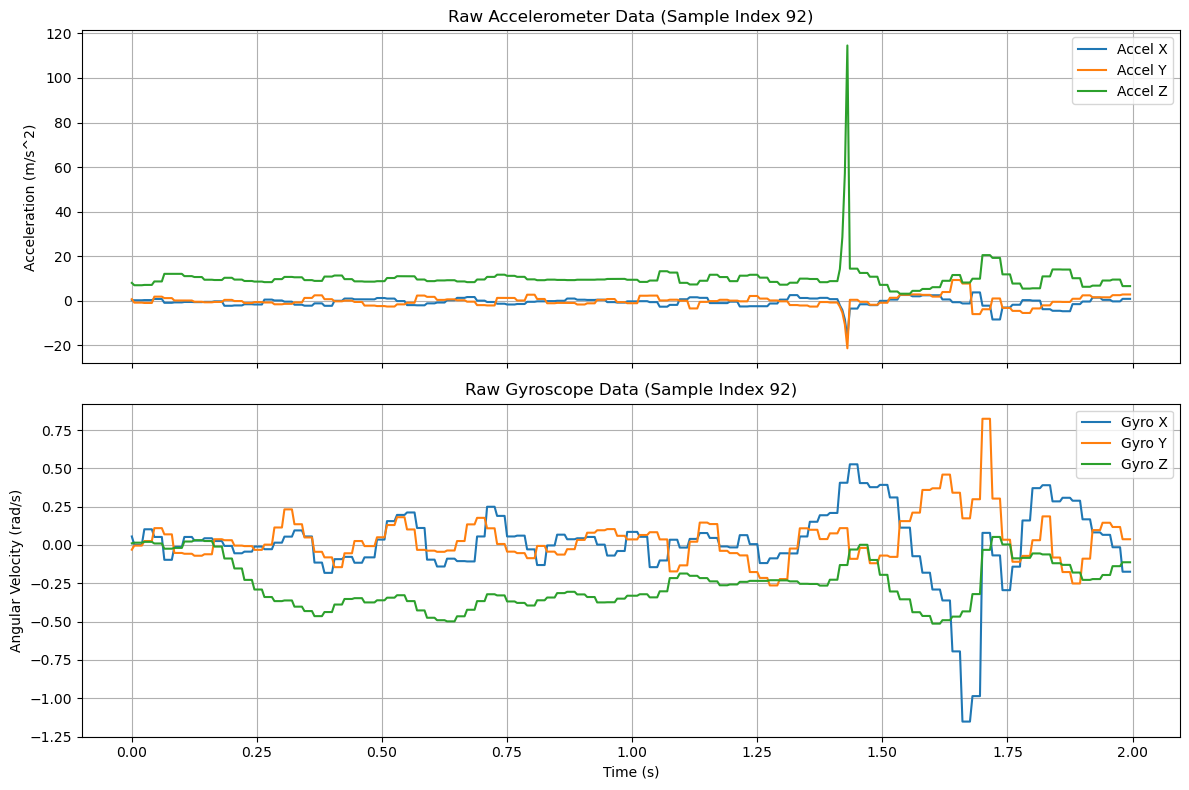


--- Plotting Visualization 2: Overall Data Distribution & Stats ---


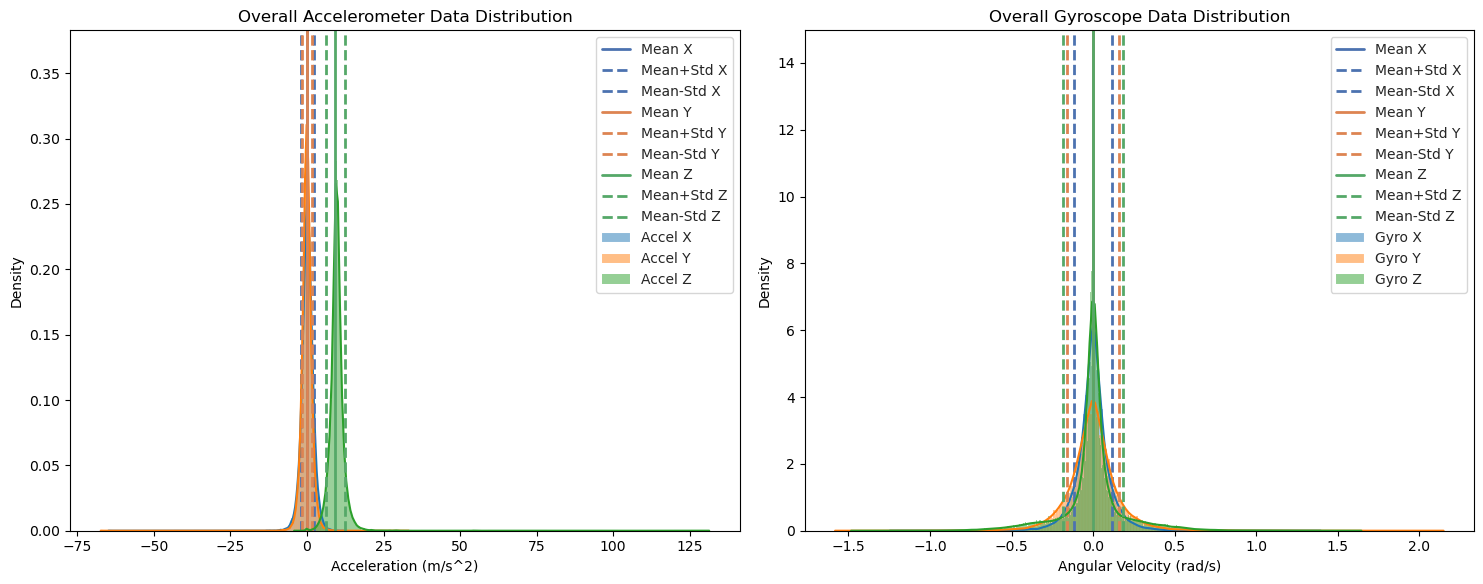


--- Plotting Visualization 3: Normalized IMU Sample ---


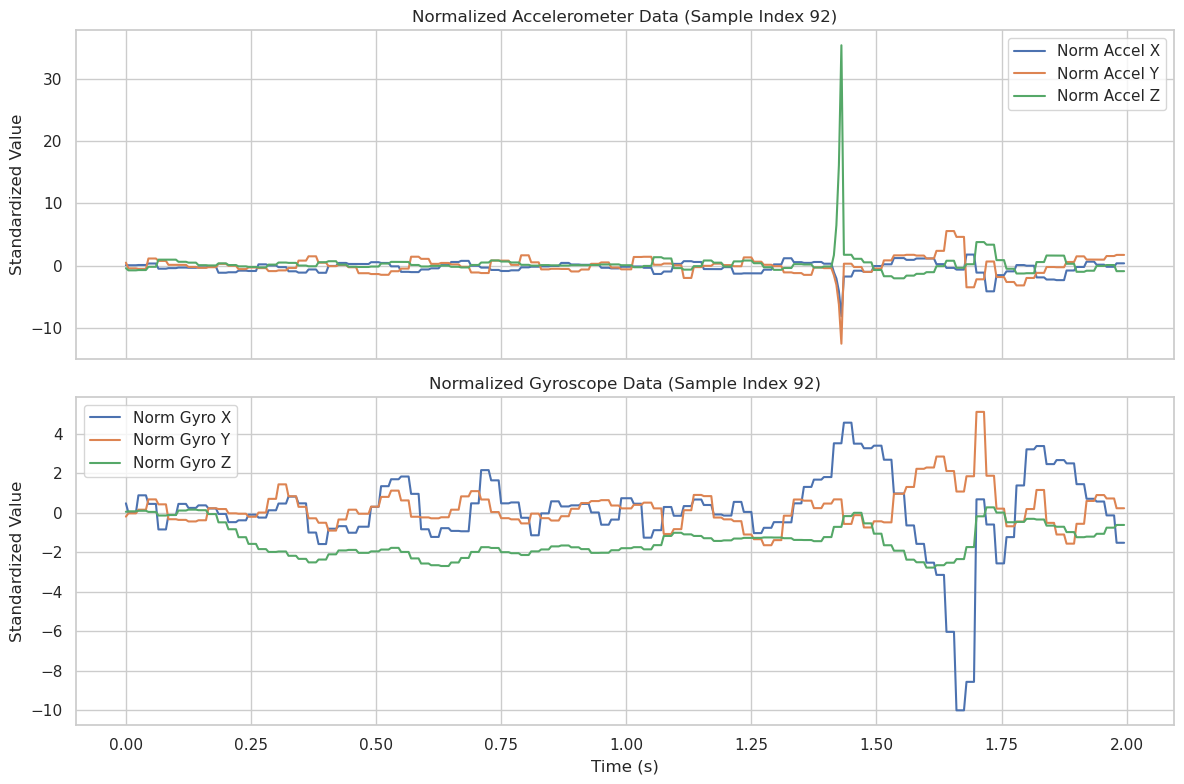


--- Plotting Visualization 4: Power Spectral Density (PSD) ---


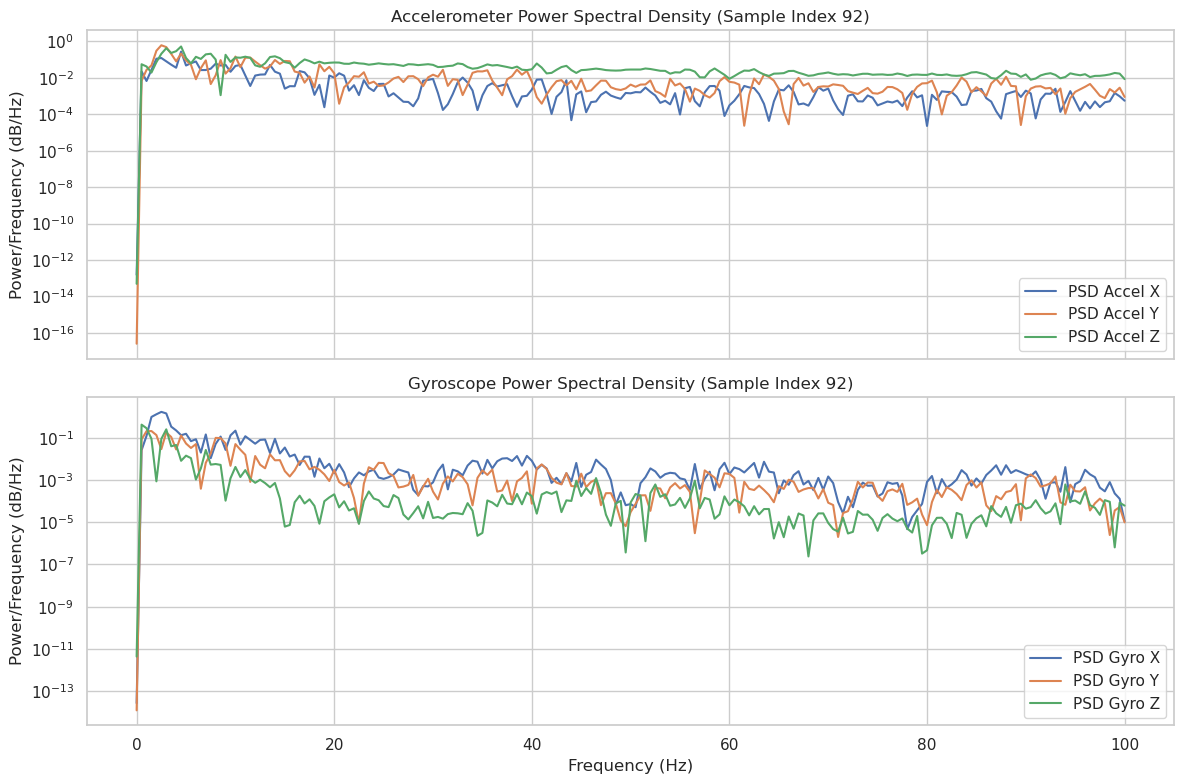


Visualizations complete.


In [4]:
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns # For nicer histograms
from scipy.signal import periodogram
import random

# --- Configuration ---
STATS_FILE = '/home/harshr/NV_cahsor/CAHSOR-master/DataProcessingPipeline/imu_stats_full_data.pkl' # Your calculated stats file
# Need to load *at least one* original pickle file to get a sample
# Ideally, point this to your dataset directory
DATA_DIR = '/mnt/sbackup/Server_3/harshr/dataset'
# Or if you just have one file for testing:
# SINGLE_DATA_FILE = '/path/to/your/data/some_file.pkl'

FREQUENCY_RATE = 200 # Hz (Must match the value used in dataset creation and stats calc)
N_SECONDS = 2      # Duration of each IMU sample window (accel_msg/gyro_msg)

# --- Load Statistics ---
print(f"Loading statistics from: {STATS_FILE}")
try:
    with open(STATS_FILE, 'rb') as f:
        stats = pickle.load(f)
    print("Statistics loaded successfully.")
    # print("Available stats keys:", stats.keys())
except FileNotFoundError:
    print(f"Error: Statistics file not found at {STATS_FILE}")
    print("Please run the statistics calculation script first.")
    exit()
except Exception as e:
    print(f"Error loading statistics file: {e}")
    exit()

# --- Load Sample Data ---
print(f"Loading sample data from directory: {DATA_DIR}")
try:
    data_files = list(Path(DATA_DIR).glob('*.pkl'))
    if not data_files:
        raise FileNotFoundError(f"No .pkl files found in {DATA_DIR}")

    # Load data from the first file found for detailed sample inspection
    sample_file_path = data_files[0]
    print(f"Using sample data from: {sample_file_path}")
    with open(sample_file_path, 'rb') as f:
        sample_data = pickle.load(f)

    # Select a random index from the sample file
    sample_idx = random.randint(0, len(sample_data['accel_msg']) - 1)
    print(f"Visualizing sample index {sample_idx} from this file.")

    # Extract one sample
    accel_sample_raw = np.array(sample_data['accel_msg'][sample_idx])
    gyro_sample_raw = np.array(sample_data['gyro_msg'][sample_idx])

    # --- Also, load ALL data for distribution plots ---
    all_accel_values = []
    all_gyro_values = []
    print("Loading all data for distribution plots (this might take a moment)...")
    for file in data_files:
         with file.open("rb") as f:
            data = pickle.load(f)
            # Ensure the keys exist and data is not empty before extending
            if 'accel_msg' in data and data['accel_msg']:
                 all_accel_values.extend(data['accel_msg'])
            if 'gyro_msg' in data and data['gyro_msg']:
                 all_gyro_values.extend(data['gyro_msg'])

    # Flatten the data for histogram: Convert list of (400, 3) arrays into one large (N*400, 3) array
    all_accel_values = np.vstack(all_accel_values)
    all_gyro_values = np.vstack(all_gyro_values)
    print(f"Loaded total {all_accel_values.shape[0]} accel readings and {all_gyro_values.shape[0]} gyro readings.")


except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the DATA_DIR path is correct and contains .pkl files.")
    exit()
except KeyError as e:
    print(f"Error: Key {e} not found in {sample_file_path}. Is the file format correct?")
    exit()
except Exception as e:
    print(f"An error occurred loading sample data: {e}")
    exit()

# --- Reshape the single sample for plotting/processing ---
# Original shape is likely (400, 3) or similar list structure per sample
# Reshape to (N_SECONDS * FREQUENCY_RATE, 3) = (400, 3) for time series
accel_sample_reshaped = accel_sample_raw.reshape(N_SECONDS * FREQUENCY_RATE, 3)
gyro_sample_reshaped = gyro_sample_raw.reshape(N_SECONDS * FREQUENCY_RATE, 3)

# Create a time axis for the sample
time_axis = np.linspace(0, N_SECONDS, N_SECONDS * FREQUENCY_RATE, endpoint=False)

# --- Visualization 1: Raw IMU Data (Single Sample) ---
print("\n--- Plotting Visualization 1: Raw IMU Sample ---")
fig1, axes1 = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
labels_axis = ['X', 'Y', 'Z']

# Accelerometer
for i in range(3):
    axes1[0].plot(time_axis, accel_sample_reshaped[:, i], label=f'Accel {labels_axis[i]}')
axes1[0].set_title(f'Raw Accelerometer Data (Sample Index {sample_idx})')
axes1[0].set_ylabel('Acceleration (m/s^2)')
axes1[0].legend()
axes1[0].grid(True)

# Gyroscope
for i in range(3):
    axes1[1].plot(time_axis, gyro_sample_reshaped[:, i], label=f'Gyro {labels_axis[i]}')
axes1[1].set_title(f'Raw Gyroscope Data (Sample Index {sample_idx})')
axes1[1].set_xlabel('Time (s)')
axes1[1].set_ylabel('Angular Velocity (rad/s)')
axes1[1].legend()
axes1[1].grid(True)

plt.tight_layout()
plt.show(block=False) # Use block=False to show plot without stopping script


# --- Visualization 2: Overall Data Distribution and Stats ---
print("\n--- Plotting Visualization 2: Overall Data Distribution & Stats ---")
fig2, axes2 = plt.subplots(1, 2, figsize=(15, 6))
sns.set_theme(style="whitegrid")

# Accelerometer Distribution
for i in range(3):
    sns.histplot(all_accel_values[:, i], ax=axes2[0], kde=True, label=f'Accel {labels_axis[i]}', stat="density", common_norm=False, alpha=0.5)
    axes2[0].axvline(stats['accel_mean'][i], color=f'C{i}', linestyle='-', linewidth=2, label=f'Mean {labels_axis[i]}')
    axes2[0].axvline(stats['accel_mean'][i] + stats['accel_std'][i], color=f'C{i}', linestyle='--', linewidth=2, label=f'Mean+Std {labels_axis[i]}')
    axes2[0].axvline(stats['accel_mean'][i] - stats['accel_std'][i], color=f'C{i}', linestyle='--', linewidth=2, label=f'Mean-Std {labels_axis[i]}')
axes2[0].set_title('Overall Accelerometer Data Distribution')
axes2[0].set_xlabel('Acceleration (m/s^2)')
axes2[0].legend(fontsize='small')

# Gyroscope Distribution
for i in range(3):
    sns.histplot(all_gyro_values[:, i], ax=axes2[1], kde=True, label=f'Gyro {labels_axis[i]}', stat="density", common_norm=False, alpha=0.5)
    axes2[1].axvline(stats['gyro_mean'][i], color=f'C{i}', linestyle='-', linewidth=2, label=f'Mean {labels_axis[i]}')
    axes2[1].axvline(stats['gyro_mean'][i] + stats['gyro_std'][i], color=f'C{i}', linestyle='--', linewidth=2, label=f'Mean+Std {labels_axis[i]}')
    axes2[1].axvline(stats['gyro_mean'][i] - stats['gyro_std'][i], color=f'C{i}', linestyle='--', linewidth=2, label=f'Mean-Std {labels_axis[i]}')
axes2[1].set_title('Overall Gyroscope Data Distribution')
axes2[1].set_xlabel('Angular Velocity (rad/s)')
axes2[1].legend(fontsize='small')

plt.tight_layout()
plt.show(block=False)

# --- Normalize the Sample ---
# Note: Dataloader reshapes to (2, 200, 3) before normalizing, but for stats application,
# (400, 3) vs (2, 200, 3) doesn't matter as mean/std are (3,) and broadcast correctly.
# Using the (400, 3) shape directly is fine here.
accel_sample_norm = (accel_sample_reshaped - stats['accel_mean']) / (stats['accel_std'] + 1e-6)
gyro_sample_norm = (gyro_sample_reshaped - stats['gyro_mean']) / (stats['gyro_std'] + 1e-6)

# --- Visualization 3: Normalized IMU Data (Single Sample) ---
print("\n--- Plotting Visualization 3: Normalized IMU Sample ---")
fig3, axes3 = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Normalized Accelerometer
for i in range(3):
    axes3[0].plot(time_axis, accel_sample_norm[:, i], label=f'Norm Accel {labels_axis[i]}')
axes3[0].set_title(f'Normalized Accelerometer Data (Sample Index {sample_idx})')
axes3[0].set_ylabel('Standardized Value')
axes3[0].legend()
axes3[0].grid(True)

# Normalized Gyroscope
for i in range(3):
    axes3[1].plot(time_axis, gyro_sample_norm[:, i], label=f'Norm Gyro {labels_axis[i]}')
axes3[1].set_title(f'Normalized Gyroscope Data (Sample Index {sample_idx})')
axes3[1].set_xlabel('Time (s)')
axes3[1].set_ylabel('Standardized Value')
axes3[1].legend()
axes3[1].grid(True)

plt.tight_layout()
plt.show(block=False)


# --- Visualization 4: Power Spectral Density (PSD) (Single Sample) ---
print("\n--- Plotting Visualization 4: Power Spectral Density (PSD) ---")
# Calculate PSD using the *normalized* data, as done in the dataloader
# The dataloader uses accel_msg.view(2 * self.frequency_rate, 3), which is the same shape we have
freqs_accel, psd_accel = periodogram(accel_sample_norm, fs=FREQUENCY_RATE, axis=0)
freqs_gyro, psd_gyro = periodogram(gyro_sample_norm, fs=FREQUENCY_RATE, axis=0)

fig4, axes4 = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Accelerometer PSD
for i in range(3):
    # Using semilogy as PSD values can span large ranges
    axes4[0].semilogy(freqs_accel, psd_accel[:, i], label=f'PSD Accel {labels_axis[i]}')
axes4[0].set_title(f'Accelerometer Power Spectral Density (Sample Index {sample_idx})')
axes4[0].set_ylabel('Power/Frequency (dB/Hz)') # Units might vary slightly depending on scaling used in periodogram
axes4[0].legend()
axes4[0].grid(True)

# Gyroscope PSD
for i in range(3):
    axes4[1].semilogy(freqs_gyro, psd_gyro[:, i], label=f'PSD Gyro {labels_axis[i]}')
axes4[1].set_title(f'Gyroscope Power Spectral Density (Sample Index {sample_idx})')
axes4[1].set_xlabel('Frequency (Hz)')
axes4[1].set_ylabel('Power/Frequency (dB/Hz)')
axes4[1].legend()
axes4[1].grid(True)

plt.tight_layout()
plt.show() # Use block=True for the last plot to keep windows open


print("\nVisualizations complete.")

# Experiment Codes

In [9]:
stats['cmd_vel_mean']

array([ 0.97144425, -0.00254578,  0.97292036, -0.00256825,  0.9743965 ,
       -0.00259858,  0.97587264, -0.00262969,  0.9773488 , -0.00266259,
        0.9788249 , -0.00268956,  0.9803011 , -0.00270476,  0.9817698 ,
       -0.00271969,  0.9830621 , -0.00273401,  0.98314434, -0.0027552 ],
      dtype=float32)

In [10]:
accel_msg1 = torch.tensor(data['accel_msg'][1])
print(accel_msg1, accel_msg1.shape)

accel_msg1 = accel_msg1.view(2, 200, 3)
print(accel_msg1.shape)

accel_msg1 = (accel_msg1 - stats['accel_mean']) / (stats['accel_std'] + 0.000006)
print(accel_msg1.shape)

accel_msg1 = periodogram(accel_msg1.view(2 * 200, 3), fs=200, axis=0)[1]
print(accel_msg1, accel_msg1.shape)

tensor([0.0000, 0.0000, 0.0000,  ..., 0.8239, 0.3593, 9.7525]) torch.Size([1200])
torch.Size([2, 200, 3])
torch.Size([2, 200, 3])
[[9.01778592e-16 3.13511397e-13 1.31615324e-12]
 [1.60145238e-02 3.79283773e-03 9.20214415e-01]
 [1.35987466e-02 3.16751213e-03 7.91176796e-01]
 [1.03944810e-02 2.49180384e-03 6.08274102e-01]
 [6.97908551e-03 1.70756713e-03 4.08338577e-01]
 [4.00761236e-03 9.90831992e-04 2.29413345e-01]
 [1.62614533e-03 3.96414340e-04 9.96108055e-02]
 [4.23596037e-04 1.32434681e-04 2.50218324e-02]
 [1.38723635e-05 1.95507596e-06 3.92336922e-04]
 [2.23332929e-04 3.64783664e-05 7.87930377e-03]
 [4.71111329e-04 1.11298126e-04 2.77389064e-02]
 [7.59540650e-04 2.08624711e-04 4.24107797e-02]
 [1.21804245e-03 1.50313659e-04 4.48799506e-02]
 [6.51161477e-04 2.07959165e-04 3.58621478e-02]
 [1.98240072e-04 7.44710051e-05 2.08258759e-02]
 [1.82883941e-05 2.56514813e-05 7.09524285e-03]
 [1.31834153e-04 2.43599043e-05 3.70913825e-04]
 [3.16314945e-05 1.83506272e-05 1.53073121e-03]
 [5.85

In [45]:

def merge(base_dict: dict, new_dict: dict):
    """Merges two dictionary together

    base_dict (dict): The base dictionary to be updated
    new_dict (dict): The new data to be added to the base dictionary
    """
    # assert base_dict is None, "Base dictionary cannot be None"
    assert (
        base_dict.keys() == new_dict.keys()
    ), "The two dictionaries must have the same keys"
    for key in base_dict.keys():
        if key == 'patches_found':
            continue
        base_dict[key].extend(new_dict[key])

    return base_dict

files = list(Path('/home/harshr/bags/').glob("*.pkl"))
data = dict()
for file in files:
    with file.open("rb") as f:
        print("Opening file")
        data =pickle.load(f)
    if bool(data):
        print("merging..")
        data = merge(data, data)
    else:
        data = data

stats = '/home/harshr/NV_cahsor/CAHSOR-master/DataProcessingPipeline/imu_stats2.pkl'
with open(stats, 'rb') as f:
    stats = pickle.load(f)

Opening file
merging..
Opening file
merging..
Opening file
merging..


In [46]:
stats.keys()

dict_keys(['accel_mean', 'accel_std', 'gyro_mean', 'gyro_std', 'accel_1sec_mean', 'accel_1sec_std', 'gyro_1sec_mean', 'gyro_1sec_std', 'accel_1m_mean', 'accel_1m_std', 'gyro_1m_mean', 'gyro_1m_std', 'accel_const_mean', 'accel_const_std', 'gyro_const_mean', 'gyro_const_std'])

In [47]:
data.keys()

dict_keys(['thermal_paths', 'left_rgb_paths', 'right_rgb_paths', 'depth_paths', 'res_vel_omega_roll_slde_bump', 'triplets', 'cmd_vel_msg', 'odom_1sec_msg', 'odom', 'odom_pose', 'accel_msg', 'gyro_msg', 'time_stamp', 'roll_pitch_yaw', 'imu_accel_1sec', 'imu_gyro_1sec', 'imu_accel_1m', 'imu_gyro_1m', 'imu_accel_const', 'imu_gyro_const'])

In [53]:
acc_vals = np.array(accel_const)
acc_vals.shape

(2066, 1200)

In [49]:
acc_vals = []
acc_vals.extend(stats['accel_const_mean'])
acc_vals = np.array(acc_vals)
acc_vals.shape

(3,)

In [ ]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
path = '/home/harshr/trial_data/depth_BL_2024-09-04_19-30-36_chunk0002/'
sd = np.load(path+'455_sparse.npy')

s = cv2.resize(sd, (256, 256), interpolation=cv2.INTER_AREA)
#np.save(path+'61_rsparse', s)
s.shape
plt.imshow(s, cmap='gray')
plt.title("Sparse Depth Map")
plt.colorbar(label="Depth")
plt.show()


ModuleNotFoundError: No module named 'pyparsing'

In [1]:
!pip install pyparsing